- CIFAR10 
    - : 10개의 클래스.50,000개의 학습데이터와 10,000개의 테스트 데이터
    - 각각의 이미지는 32x32x3 shape를 가진 아주 작은 컬러 이미지이다.

- 구현방식
  - 실제 논문에서의 구현방식과 동일하다. (아래 그림)
  - ImageNet의 아키텍처를 따르며, 입력단의 크기만 CIFAR10에 맞게 바꾼다.

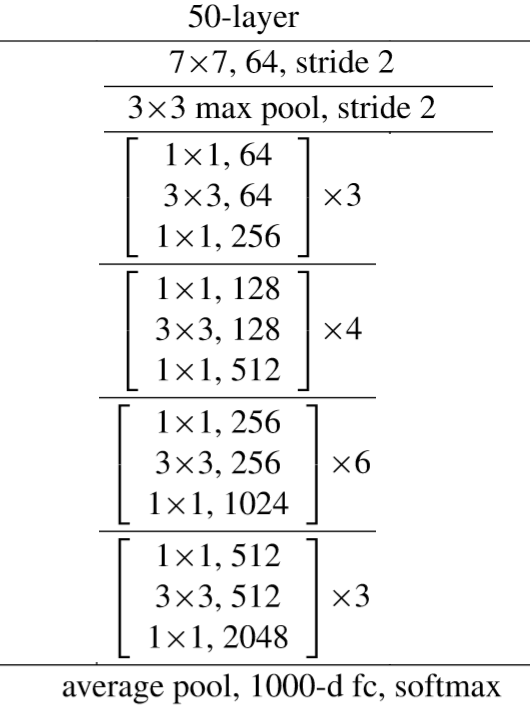

### block 및 함수 설명

- convolution_block(), identity_block()
  - 각 block은 논문 상에서의 block 하나를 의미함
  - 하나의 block은 3개의 convolution layer로 구성되어있다.

- identity_block()은 input size과 output size가 동일한 경우에만 f(x)+x 를 수행할 수 있다. 두 size가 다를 경우에는 단순히 f(x)에 x를 추가할 수 없다.
- 그래서 다음 stage로 넘어갈 때에 convolution_block()을 통해 다른 크기의 입력을 수행한다.
  - convolution_block에서는 shortcut과정에서 conv_layer가 하나 더 추가되어, 이전 출력 값인 x의 크기를 f(x)와 동일하게 만들어 준다. 


- Resnet50()
  - convolution_block과 identity_block을 연속적으로 연결한다.

### 구현 과정

- 각 block내에서는 먼저 conv1 layer를 거치고 batch normalization과 relu를 수행하는 과정을 두 번 반복하고, conv3 + batch를 수행한다.
- 이후 3개의 convolution을 거친 결과 f(x)에 input x를 더하고 relu를 씌운다.
- 그리고 block들을 Resnet50() 을 통해 여러 번 연결한다.


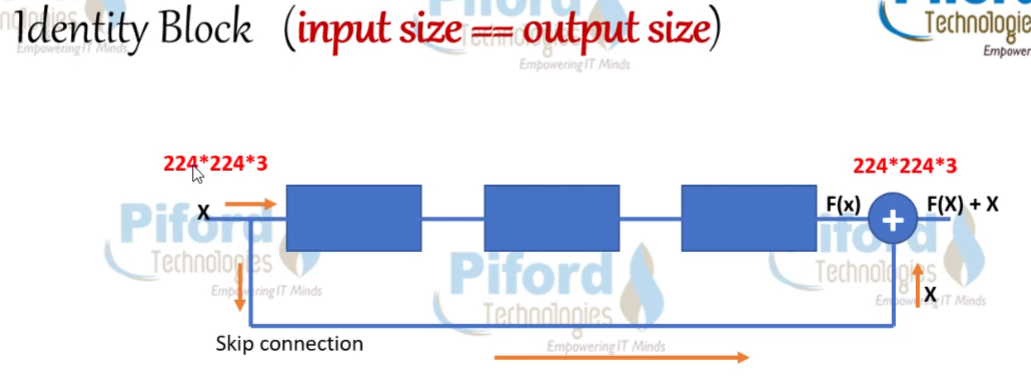

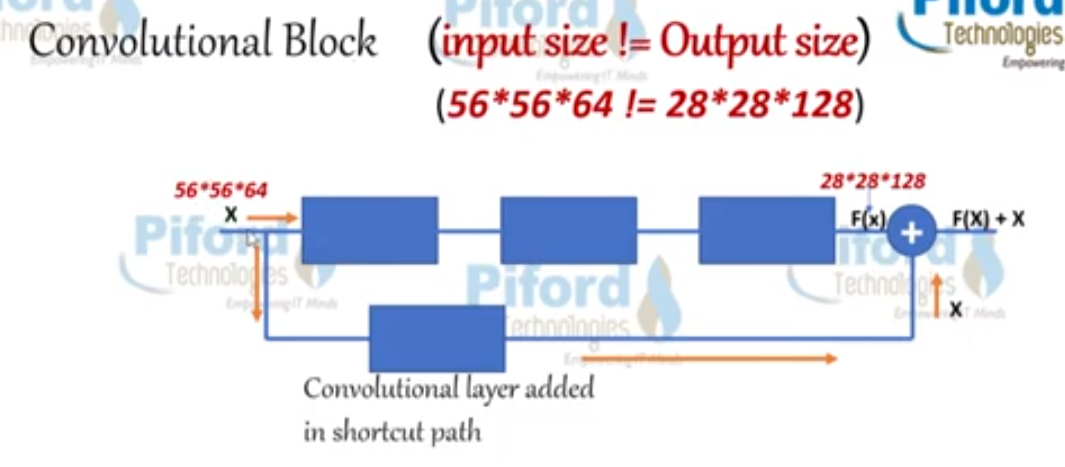

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from keras.initializers import glorot_uniform

from tensorflow.keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 11s 0us/step


In [2]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

# 정규화 0~1 사이의 값으로
x_train = x_train.astype(np.float32) / 255.0
x_train = x_train.astype(np.float32) / 255.0

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000, 1)


In [3]:
"""
Arguments:
X -- input of shape (m, height, width, channel)
f -- shape of the middle CONV's window for the main path
filters -- python list of integers, defining the number of filters in the CONV layers of the main path
stage -- integer, used to name the layers, depending on their position in the network
block -- string/character, used to name the layers, depending on their position in the network

Returns:
X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
"""



# f(kernel_size) =3
# filters = [F1, F2, F3] 한 블록 내의 각 레이어의 filter 개수

def identity_block(X, f, filters, stage, block):

    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # filters = [F1, F2, F3] 한 블록 내의 각 레이어의 filter 개수 
    F1, F2, F3 = filters   # filters=[64,64,256] F1=64, F2=64, F3=256
    
    # 입력 값(실제 값) 저장. 나중에 출력에 추가하기 위해 필요함
    X_shortcut = X
    
    # x의 값을 업데이트
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    # Second component of main path 
    # kernel_size = 3*3 by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    # 마지막 layer에서는 bn후에 activation을 수행하지 않음
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: main path에 shortcut 값을 더하고, RELU를 통해 전달한다.  
    X = Add()([X, X_shortcut]) # F(x)+x
    X = Activation('relu')(X)
    
    return X

In [4]:
# 다음 stage로 넘어갈 때에 convolution_block()을 통해 다른 크기의 입력을 수행한다.
# convolution_block에서는 shortcut과정에서 conv_layer가 하나 더 추가되어, 이전 출력 값인 x의 크기를 f(x)와 동일하게 만들어 준다.

def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)
      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third layer
    # 마지막 layer에서는 bn후에 activation을 수행하지 않음
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    # Conv2D를 하나 더 추가하여, shortcut(input)을 마지막 layer와 동일한 크기로 만든다.
    # (15-1)/2+1 = 8
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: 여기에 shortcut 값을 추가하고 RELU 활성화를 통해 전달한다.
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

input_size = (56* 56 * 64) output_size=(28* 28* 128) 일 때,두 가지 방법으로 output_size와 매칭시킬 수 있다.
- input_size를 padding 
- kernel_size=(1*1) convolution 수행

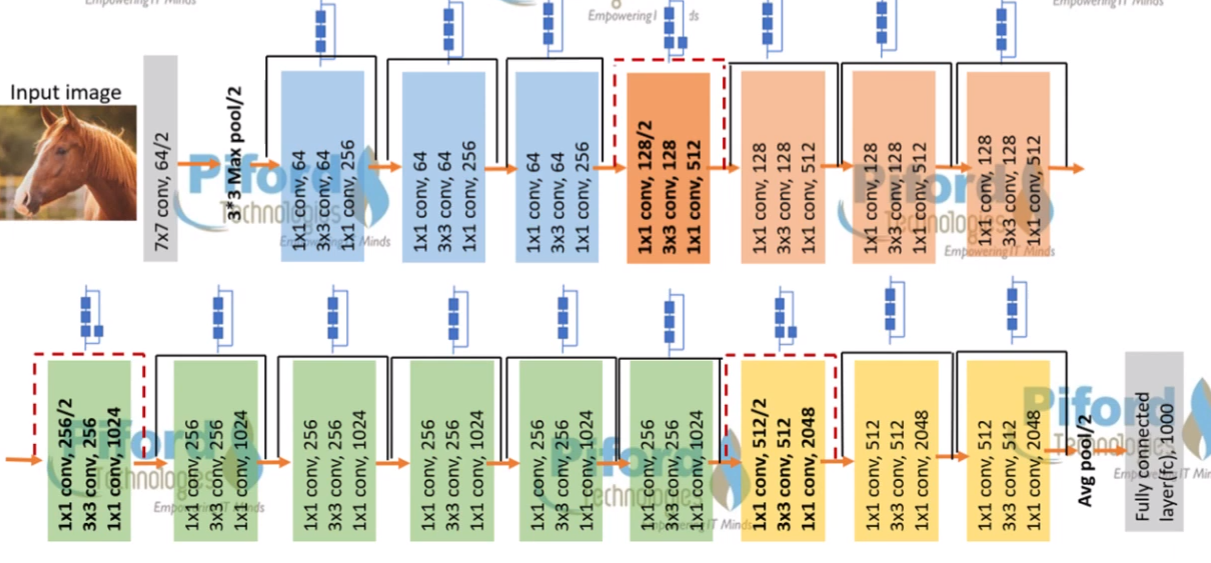

In [5]:
#Each ResNet block is either 2 layer deep

"""
Implementation of the ResNet50 architecture:
CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
-> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

"""

def ResNet50(input_shape, classes):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
#    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7 
#    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
#    X = Activation('relu')(X)
#    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3  

    # 데이터 사이즈에 맞춰 strides를 1로 변경
    X = Conv2D(64, (7, 7), strides=(1, 1), name='conv1')(X) #64 filters of 7*7 
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3
    
    # filters = [F1, F2, F3] 한 블록 내의 각 레이어의 filter 개수
    # Stage 2 - 3번 반복
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)  
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    ### START CODE HERE ###

    # Stage 3 - 4
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 - 6
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 - 3
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [6]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

""" 에러 발생 시, compile을 위와 같이 변경
Shapes (None, 1) and (None, 10) are incompatible
- 참고 : https://wikidocs.net/74691

"""

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:

model.fit(x_train, y_train, epochs = 5, batch_size=100) # batch_size

Epoch 1/5
500/500 [==============================] - 6298s 13s/step - loss: 1.7202 - accuracy: 0.4201
Epoch 2/5
500/500 [==============================] - 6946s 14s/step - loss: 1.3149 - accuracy: 0.5456
Epoch 3/5
500/500 [==============================] - 6056s 12s/step - loss: 1.0772 - accuracy: 0.6242
Epoch 4/5
444/500 [=========================>....] - ETA: 11:59 - loss: 0.9691 - accuracy: 0.6656

In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

- 참고 자료:
    - https://www.youtube.com/watch?v=glmowUlqoYw
    - https://github.com/AarohiSingla/ResNet50/blob/master/3-resnet50_rooms_dataset%20-%20Copy.ipynb
